# Decadal Drought Trends
Combining the historical and RCP8.5 files to get an estimate for the total amount of drought in the Western US 
- We first look at the grid level and count the number of "severe" (D2+) drought classifications
- Potential to look at regions or across the entire Western US

In [1]:
from imports import *
from netCDF4 import Dataset # for saving netcdfs 
from cartopy.feature import ShapelyFeature # for plotting HUC2 regions
from cartopy.io.shapereader import Reader
from joblib import Parallel, delayed
import scipy.stats as st # for easy confidence intervals using student-t

# axes grid for 
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes


states = cfeature.NaturalEarthFeature(category='cultural',
                                     name='admin_1_states_provinces_shp',
                                     scale='50m',
                                     facecolor='none',
                                     edgecolor='black',
                                     linewidth=1)

In [2]:
def plot_west(DataArray, title, colortitle, color, vmin, vmax):
    """Function to quickly plot an x-array object onto US West map"""
    # plot mask
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(16,8))

    # get snow cmap
    cmap = matplotlib.cm.get_cmap(color)
    #snow_cmap.set_bad(color='gray')

    # get states
    states = cfeature.NaturalEarthFeature(category='cultural',
                                         name='admin_1_states_provinces_shp',
                                         scale='50m',
                                         facecolor='none',
                                         edgecolor='black',
                                         linewidth=1)

    # get HUC2 regions 
    HUC2 = ShapelyFeature(Reader("/work/Julian.Schmitt/data/shape/huc2_regions.shp").geometries(),
                                 crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1.5)

    # load projection
    ax = plt.axes(projection=ccrs.PlateCarree())

    # add land, lakes, oceans, and HUC2 regions
    ax.add_feature(cfeature.LAND, edgecolor="orange", facecolor="grey", zorder=0)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor="blue")
    ax.add_feature(cfeature.OCEAN, zorder=2)
    #ax.add_feature(HUC2)
    # add states 
    ax.add_feature(states, edgecolor='black', linewidth=4)



    # define new regionmask where values represent drought conditions
    # uncomment when doing different year - save computation speed for now

    data = DataArray.plot(ax=ax, transform = ccrs.PlateCarree(), add_colorbar=False,
             cmap=cmap, zorder=1, vmin=vmin, vmax=vmax)

    #cax = divider.append_axes('right', size='5%', pad=0.05)
    # fig.colorbar(cmap=newcmp, ax=ax, cax=cax)


    cbar = plt.colorbar(data, 
                       orientation='vertical',
                       shrink=0.8)
    #cbar.ax.set_yticklabels(yticklabels)
    cbar.set_label(colortitle)


    # set extent to Western US
    ax.set_extent((-130, -105, 30, 53), crs=ccrs.PlateCarree())

    # set plot attributes and labels
    ax.set_title(title);
    return ax

In [8]:
# open dataset with masked regions as example
mask_ds = xr.open_dataset("/work/Julian.Schmitt/data/climatology/ensemble/snow/SPEAR_median_yearly_swemax.nc")

<GeoAxesSubplot:title={'center':'SPEAR Snow Climatology'}, xlabel='lon', ylabel='lat'>

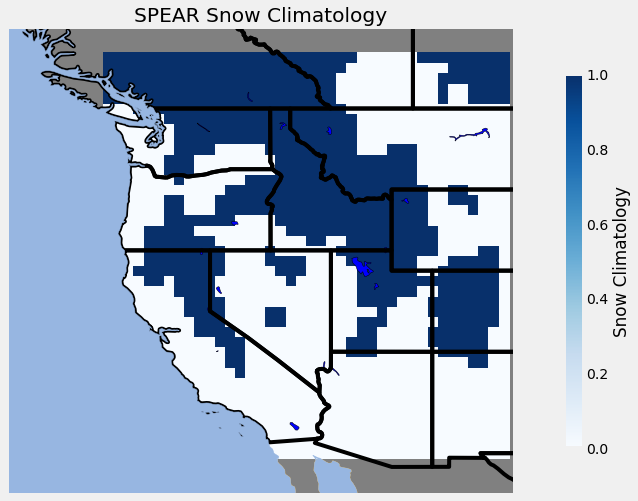

In [4]:
# plot dataset
plot_west((mask_ds.snow>20), "SPEAR Snow Climatology", "Snow Climatology", "Blues", 0, 1)

In [26]:
# gets number of snowy grid cells - eg sample size for given timestamp
num_snowy = np.array(mask_ds.snow >20).flatten().sum()

# Compute Drought by Decade for Ensemble mean
Guessing this plot will be much more bland than for an individual ensemble member

In [2]:
def to_decadal(rootdir, ens_num: str, threshold : float=-1.3):
    """Computes decadal frequency of Snow Drought (eg D2 snow drought) across the US West"""
    # get files
    hist_file = os.path.join(rootdir, f"hist/hist_monthly_ens_{ens_num}.nc")
    future_file = os.path.join(rootdir, f"future/future_monthly_ens_{ens_num}.nc")
    
    # open datsets and concat
    hist_zscores = xr.open_dataset(hist_file)
    future_zscores = xr.open_dataset(future_file)
    zscores = xr.concat([hist_zscores, future_zscores], dim='time').sortby('time')

    
    # reindex to West CONUS (remove Canada) and convert time to pandas
    zscores = zscores.reindex(lat = zscores.lat[zscores.lat <=49])
    zscores = zscores.sel(time=is_winter(zscores['time.month']))
    #zscores['time'] = zscores.indexes['time'].to_datetimeindex()
    
    # resample to 10 year frequency
    zscores = (zscores < threshold).resample(time="10Y", closed='left').sum()
    
        
    # open mask for snowy region and add time dimension corresponding to zscores
    mask_ds = xr.open_dataset("/work/Julian.Schmitt/data/climatology/ensemble/snow/SPEAR_median_yearly_swemax.nc")
    mask = mask_ds.expand_dims(dim={'time': zscores.time})
    
    # mask to snowy regions
    zscores = zscores.where(mask.snow > 20)
    
    return zscores

In [3]:
%%time
def is_winter(month):
    return (month <=4) | (month >=10)
rootdir = "/work/Julian.Schmitt/data/zscores/snowi/"
all_ens_members = [to_decadal(rootdir, str(i).zfill(2)) for i in range(1, 31)]

CPU times: user 2.85 s, sys: 789 ms, total: 3.64 s
Wall time: 10.9 s


In [4]:
# get the ensemble mean
ens_mean = sum([ens.zscores for ens in all_ens_members])/30

In [20]:
def plot_decadal(dataset, title: str = "Severe Snow Drought Occurance by Decade for SPEAR-MED Ensemble Mean"):
    """Plots decadally aggregated snow drought frequency spatially"""
    projection = ccrs.PlateCarree()
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    cmap = matplotlib.cm.get_cmap("RdBu_r")
    cmap.set_bad(color='gray')
    vmin, vmax = 0, 100
    fig = plt.figure(figsize=(30,20))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(3, 6),
                    axes_pad=0.4,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    label_mode='')  # note the empty label_mode

    for i, ax in enumerate(axgr):
        #i=j+1
        if i >18: # truncate after 18 steps - can adjust in addition to axgr object
            break
        
        # add background features and set map extent
        ax.add_feature(cfeature.LAND, edgecolor="orange", facecolor="grey", zorder=0)
        ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor="blue")
        ax.add_feature(cfeature.OCEAN, zorder=2)
        ax.set_extent((-130, -105, 30, 53), crs=ccrs.PlateCarree())
        ax.add_feature(states, edgecolor='black', linewidth=3)
        
        # add data
        data = (dataset[i]/70*100).where(mask_ds.snow >20).plot(ax=ax, transform = projection, add_colorbar=False,
                 cmap=cmap, zorder=1, vmin=vmin, vmax=vmax)
        
        # set title by decade
        decade = dataset.indexes['time'][i].year // 10 * 10 -10
        ax.set_title(f"{decade}s")
    
    # add colorbar, title, and colorbar label
    axgr.cbar_axes[0].colorbar(data)
    fig.suptitle(title, y=0.82, fontsize=35)
    fig.text(0.97, 0.30, 'Percentage of Months Presenting as SD', rotation=90, fontsize=25)
    return fig

In [23]:
def plot_decadal_samp(dataset, title: str = "Severe Snow Drought Occurance by Decade for SPEAR-MED Ensemble Mean"):
    """Plots decadal map for selected times - useful for poster or presentation figures"""
    projection = ccrs.PlateCarree()
    axes_class = (GeoAxes,
                  dict(map_projection=projection))
    cmap = matplotlib.cm.get_cmap("RdBu_r")
    cmap.set_bad(color='gray')
    vmin, vmax = 0, 100
    fig = plt.figure(figsize=(30,20))
    axgr = AxesGrid(fig, 111, axes_class=axes_class,
                    nrows_ncols=(2, 3),
                    axes_pad=0.65,
                    cbar_location='right',
                    cbar_mode='single',
                    cbar_pad=0.2,
                    cbar_size='3%',
                    label_mode='')  # note the empty label_mode

    for k, ax in enumerate(axgr):
        i = [0,5,8,11,13,17][k]
        #i=j+1
        if i >18: # truncate after 18 steps - can adjust in addition to axgr object
            break
        
        # add background features and set map extent
        ax.add_feature(cfeature.LAND, edgecolor="orange", facecolor="grey", zorder=0)
        ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor="blue")
        ax.add_feature(cfeature.OCEAN, zorder=2)
        ax.set_extent((-130, -105, 30, 53), crs=ccrs.PlateCarree())
        ax.add_feature(states, edgecolor='black', linewidth=3)
        
        # add data
        data = (dataset[i]/70*100).where(mask_ds.snow >20).plot(ax=ax, transform = projection, add_colorbar=False,
                 cmap=cmap, zorder=1, vmin=vmin, vmax=vmax)
        
        # set title by decade
        decade = dataset.indexes['time'][i].year // 10 * 10 -10
        ax.set_title(f"{decade}s", fontsize=40)
    
    # add colorbar, title, and colorbar label
    axgr.cbar_axes[0].tick_params(labelsize=35)
    axgr.cbar_axes[0].colorbar(data)
    fig.suptitle(title, y=0.93, fontsize=50)
    fig.text(0.98, 0.20, 'Percentage of Months Presenting as SD', rotation=90, fontsize=45)
    return fig

/nbhome/Julian.Schmitt/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  import sys
/nbhome/Julian.Schmitt/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


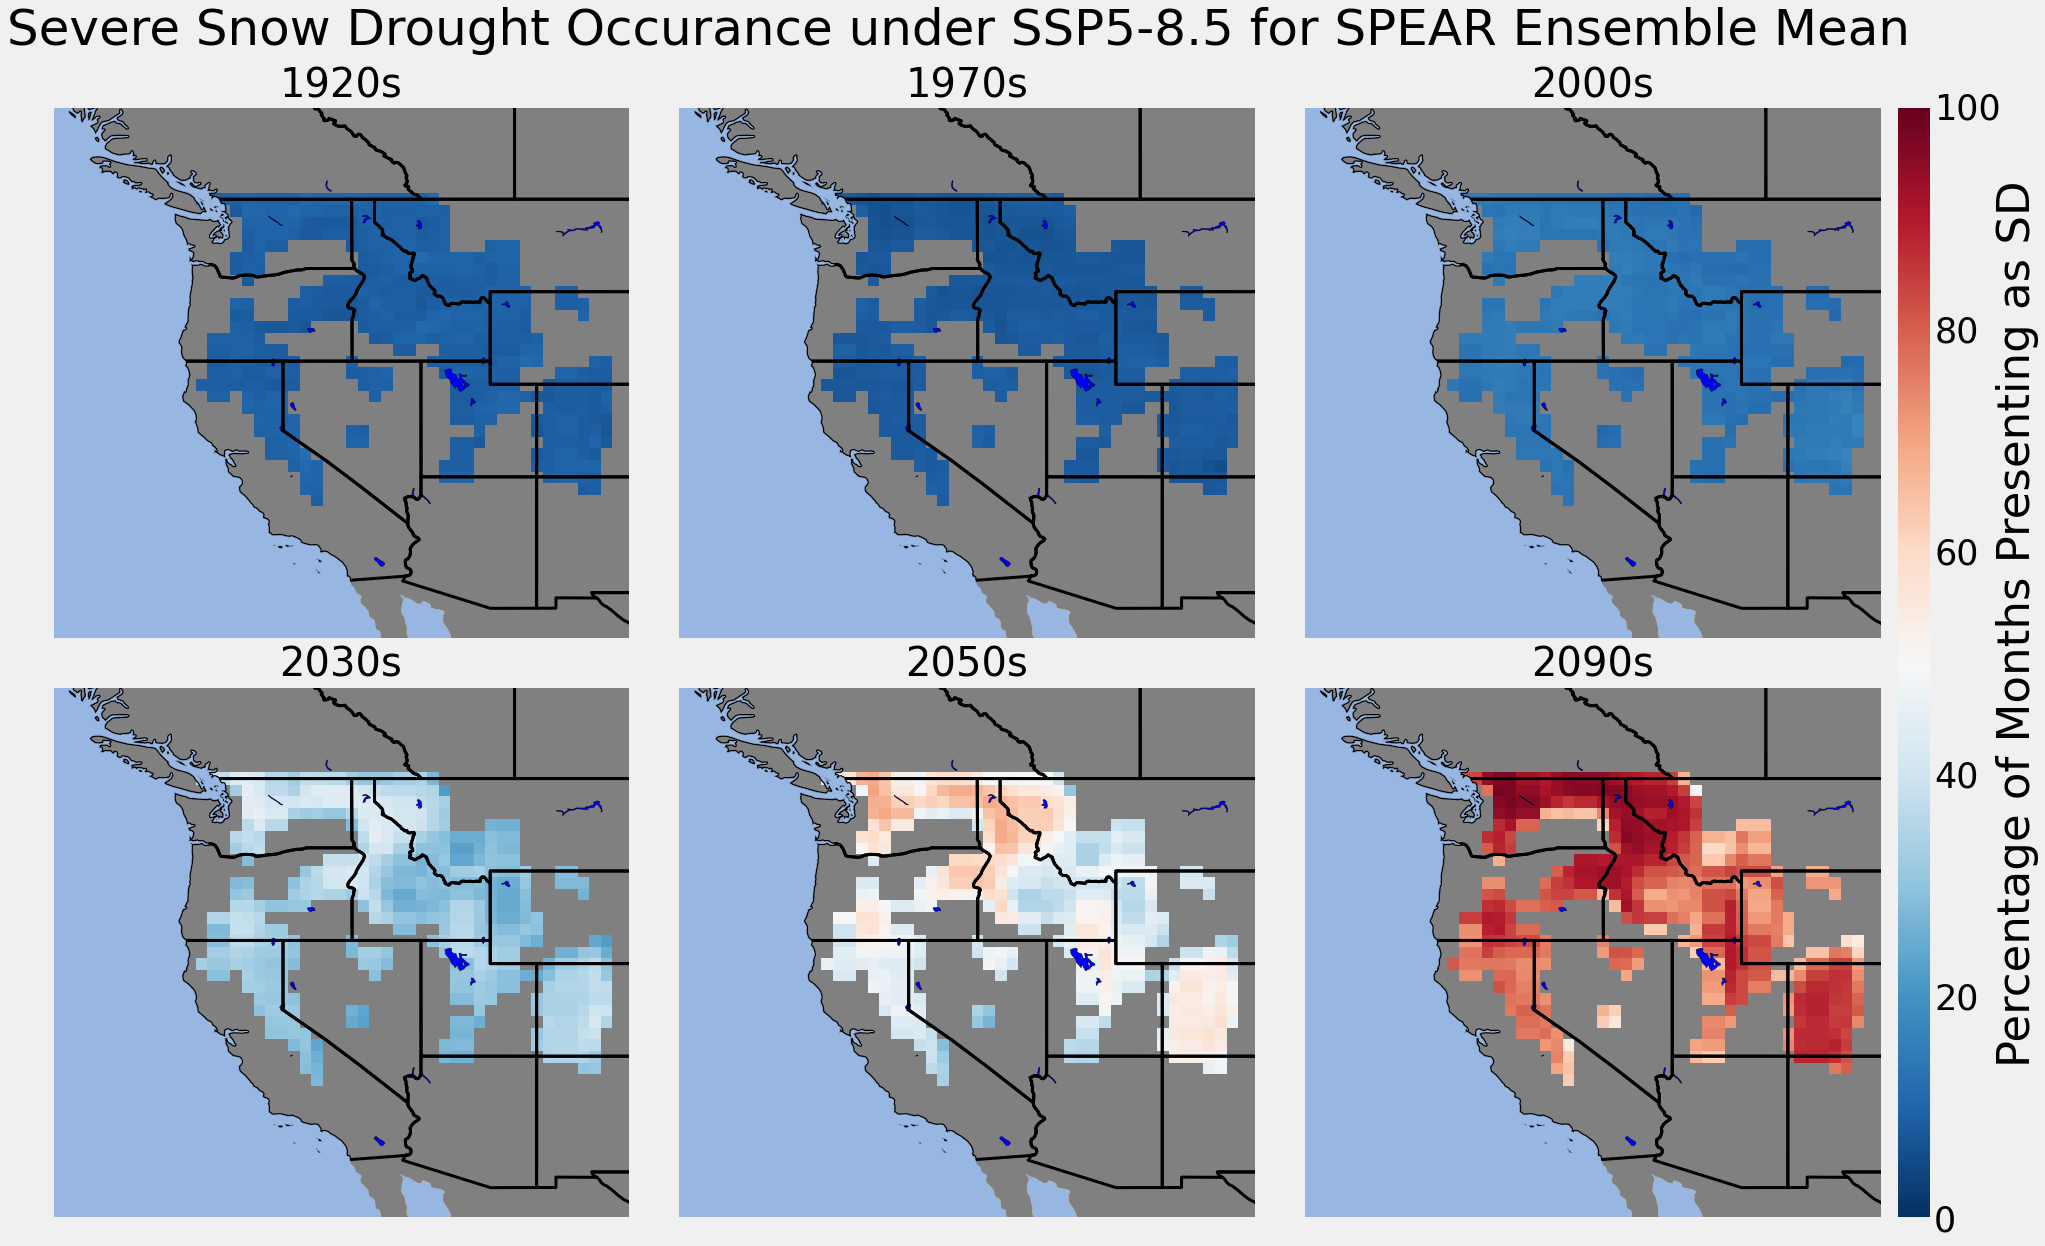

In [24]:
# plot sample conditions
plt.style.use('fivethirtyeight')
f = plot_decadal_samp(ens_mean, "Severe Snow Drought Occurance under SSP5-8.5 for SPEAR Ensemble Mean")
f.savefig("/home/Julian.Schmitt/plots/ensemble_mean_severe_SD_by_decade_ssp585_sampleb.png", dpi=350)

/nbhome/Julian.Schmitt/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  import sys
/nbhome/Julian.Schmitt/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


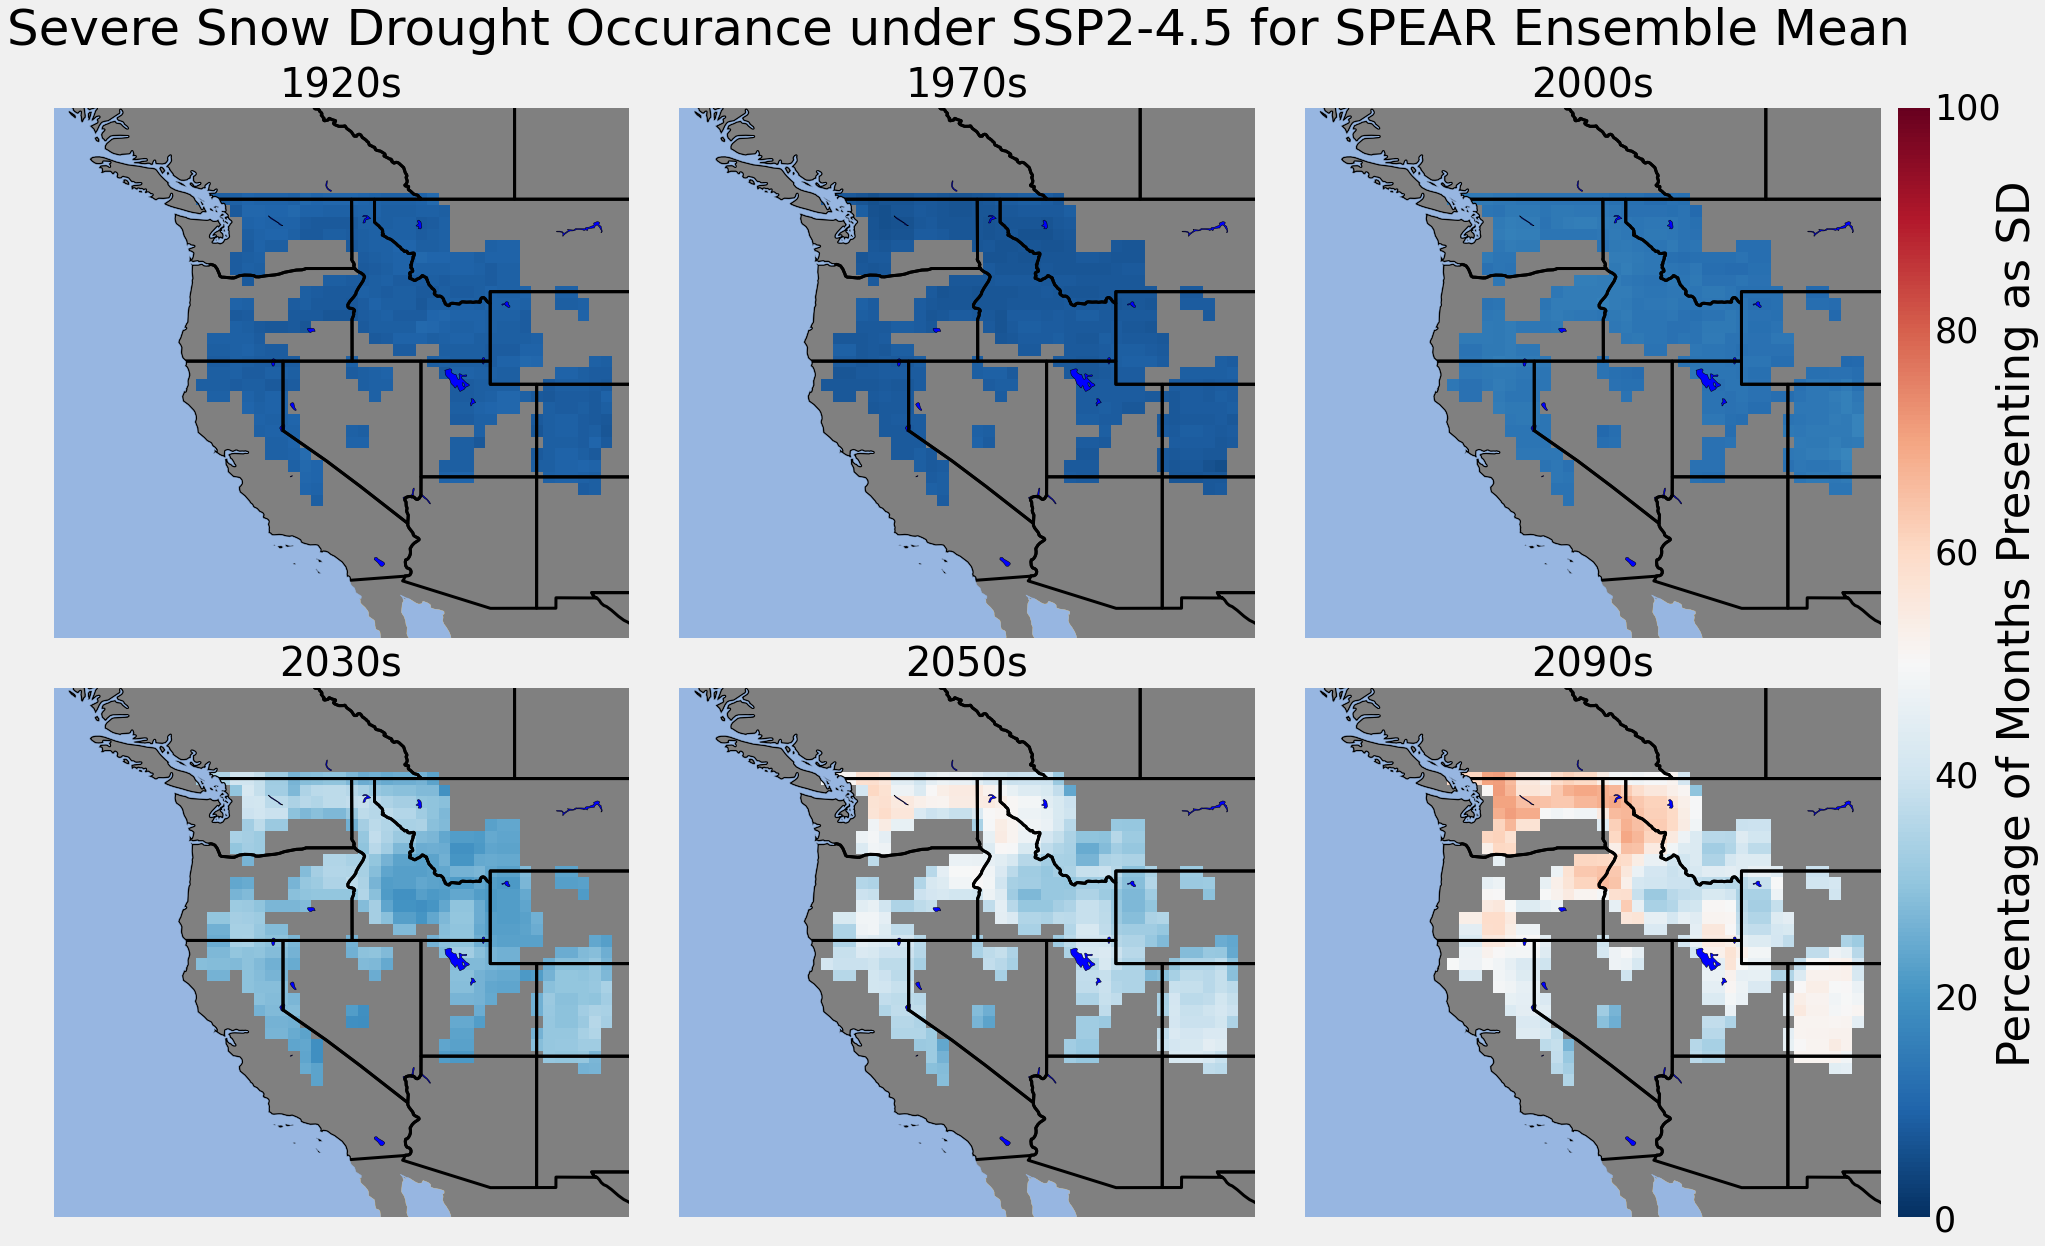

In [30]:
# repeat analysis for SSP2-4.5
f245 = plot_decadal_samp(ens_mean45, "Severe Snow Drought Occurance under SSP2-4.5 for SPEAR Ensemble Mean")
f245.savefig("/home/Julian.Schmitt/plots/ensemble_mean_severe_SD_by_decade_ssp245_sampleb.png", dpi=350)

## Ensemble Spread of Total Drought Months for the Western US
- we divide by `num_snowy` to get a more interpretable measure of the average number of drought months by region as opposed to the total count across all regions.

In [31]:
# drop the spatial dimension - here we look at the overall Western US trend
agg_ens_drought = [np.array(ens.groupby('time').sum(['lat', 'lon']).zscores)/num_snowy
                                                                   for ens in all_ens_members]

In [32]:
# access data for RCP4.5
def to_decadal(rootdir, ens_num: str, threshold : float=-1.3):
    # get files
    hist_file = os.path.join(rootdir, f"hist/hist_monthly_ens_{ens_num}.nc")
    future_file = os.path.join(rootdir, f"future245/future_monthly_ens_{ens_num}.nc")
    
    # open datsets and concat
    hist_zscores = xr.open_dataset(hist_file)
    future_zscores = xr.open_dataset(future_file)
    zscores = xr.concat([hist_zscores, future_zscores], dim='time').sortby('time')

    
    # reindex to West CONUS (remove Canada) and convert time to pandas
    zscores = zscores.reindex(lat = zscores.lat[zscores.lat <=49])
    zscores = zscores.sel(time=is_winter(zscores['time.month']))
    #zscores['time'] = zscores.indexes['time'].to_datetimeindex()
    
    # resample to 10 year frequency
    zscores = (zscores < threshold).resample(time="10Y", closed='left').sum()
    
        
    # open mask for snowy region and add time dimension corresponding to zscores
    mask_ds = xr.open_dataset("/work/Julian.Schmitt/data/climatology/ensemble/snow/SPEAR_median_yearly_swemax.nc")
    mask = mask_ds.expand_dims(dim={'time': zscores.time})
    
    # mask to snowy regions
    zscores = zscores.where(mask.snow > 20)
    
    return zscores

rootdir45 = "/work/Julian.Schmitt/data/zscores/snowi/"
all_ens_members45 = [to_decadal(rootdir45, str(i).zfill(2)) for i in range(1, 31)]


In [33]:
# get ensemble mean for 4.5
ens_mean45 = sum([ens.zscores for ens in all_ens_members45])/30

# aggregate/sum by decade for total drought months
agg_ens_drought45 = [np.array(ens.groupby('time').sum(['lat', 'lon']).zscores)/num_snowy
                                                                 for ens in all_ens_members45]
# get ensemble mean averages 
agg_ens_mean45 = ens_mean45.groupby('time').sum(['lat', 'lon'])/num_snowy
agg_ens_mean = ens_mean.groupby('time').sum(['lat', 'lon'])/num_snowy

In [34]:
# confidence intervals for ensemble mean
dates = np.arange(1920, 2100, 10)
CI45s = []
for ind, decade in enumerate(dates):
    data = [agg_ens_drought45[i][ind] for i in range(len(agg_ens_drought45))]
    CI = st.t.interval(alpha=0.95, df = len(data)-1, loc=np.mean(data), scale=st.sem(data))
    CI45s.append(CI)
CI45_low = [elt[0] for elt in CI45s]
CI45_high = [elt[1] for elt in CI45s]

CI85s = []
for ind, decade in enumerate(dates):
    data = [agg_ens_drought[i][ind] for i in range(len(agg_ens_drought))]
    CI = st.t.interval(alpha=0.95, df = len(data)-1, loc=np.mean(data), scale=st.sem(data))
    CI85s.append(CI)
CI85_low = [elt[0] for elt in CI85s]
CI85_high = [elt[1] for elt in CI85s]

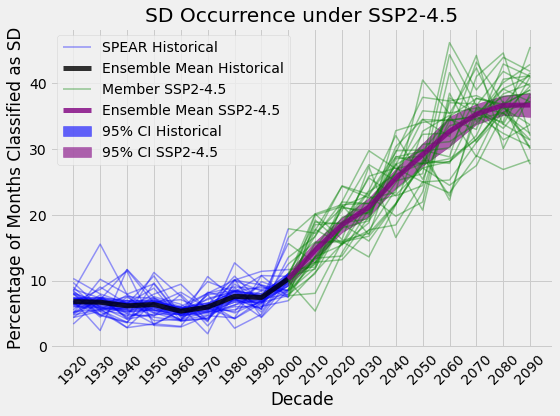

In [38]:
# plot
dates = np.arange(1920, 2100, 10)
fig = plt.figure(figsize=(8,6))
############ HISTORICAL ##########
# add ensemble members
for ind, ens_member in enumerate(agg_ens_drought45):
    if ind ==1: # only add one legend label, convert to percentage
        plt.plot(dates[:9], (ens_member[:9] /70*100), color='blue', linewidth=1.5, alpha=0.4, label="SPEAR Historical")
    else:
        plt.plot(dates[:9], (ens_member[:9] /70*100), color='blue', linewidth=1.5, alpha=0.4)

# add ensemble mean
plt.plot(dates[:9], (agg_ens_mean45[:9] /70 *100), color='k', linewidth=5, alpha=0.8, label="Ensemble Mean Historical")

# add CI
plt.fill_between(dates[:9], (np.array(CI45_low[:9])/70*100), (np.array(CI45_high[:9])/70*100), color='blue', alpha=0.6, label="95% CI Historical")
###################################

############# RCP 4.5 ############
# add ensemble members
for ind, ens_member in enumerate(agg_ens_drought45):
    if ind ==1: # only add one legend label, convert to percentage
        plt.plot(dates[8:], (ens_member[8:] /70*100), color='green', linewidth=1.5, alpha=0.4, label="Member SSP2-4.5")
    else:
        plt.plot(dates[8:], (ens_member[8:] /70*100), color='green', linewidth=1.5, alpha=0.4)

# add ensemble mean
plt.plot(dates[8:], (agg_ens_mean45[8:] /70 *100), color='purple', linewidth=5, alpha=0.8, label="Ensemble Mean SSP2-4.5")

# add CI
plt.fill_between(dates[8:], (np.array(CI45_low[8:])/70*100), (np.array(CI45_high[8:])/70*100), color='purple', alpha=0.6, label="95% CI SSP2-4.5")
###################################

############ RCP 8.5 ##############
# add ensemble members
for ind, ens_member in enumerate(agg_ens_drought):
    if ind ==1: # only add one legend label
        plt.plot(dates[8:], (ens_member[8:] /70*100), color='orange', linewidth=1.5, alpha=0.4, label="Member SSP5-8.5")
    else:
        plt.plot(dates[8:], (ens_member[8:] /70*100), color='orange', linewidth=1.5, alpha=0.4)

# add ensemble mean
plt.plot(dates[8:], (agg_ens_mean[8:] /70*100), color='red', linewidth=4, alpha=0.8, label="Ensemble Mean SSP5-8.5")

plt.fill_between(dates[8:], (np.array(CI85_low[8:]) /70*100), (np.array(CI85_high[8:]) /70*100), color='red', alpha=0.6, label = "95% CI SSP5-8.5")




# add labels
plt.title("SD Occurrence under SSP2-4.5 and SSP5-8.5")
plt.xlabel("Decade")
plt.ylabel("Percentage of Months Classified as SD")
plt.legend()
plt.xticks(dates, rotation=45);
plt.tight_layout()
plt.savefig("/home/Julian.Schmitt/plots/tot_SDmo_SSP2-4.5_and_5-8.5_comparison.png", dpi=250)

/nbhome/Julian.Schmitt/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  import sys
/nbhome/Julian.Schmitt/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


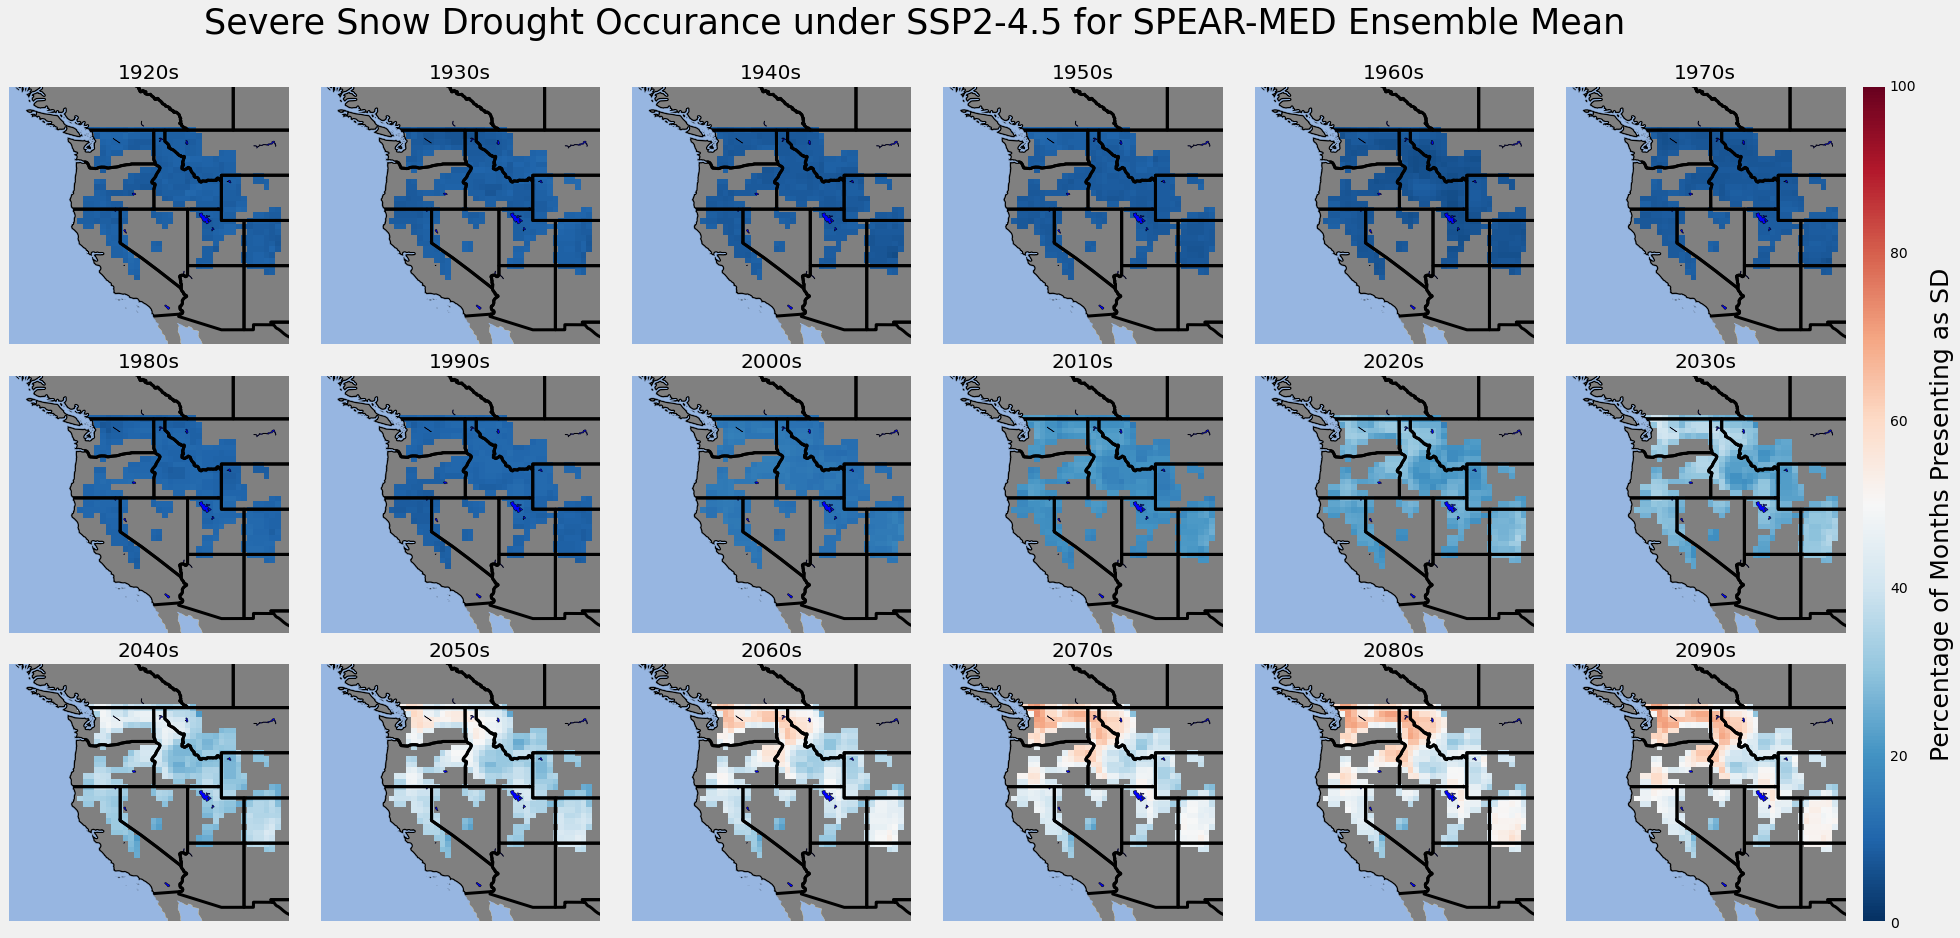

In [42]:
f45 = plot_decadal(ens_mean45, "Severe Snow Drought Occurance under SSP2-4.5 for SPEAR-MED Ensemble Mean")
f45.savefig("/home/Julian.Schmitt/plots/ensemble_mean_severe_SD_245_decadal.png", dpi=350)

/nbhome/Julian.Schmitt/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  """
/nbhome/Julian.Schmitt/miniconda3/envs/noaa2/lib/python3.6/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.


Text(0.97, 0.33, 'Number of Winter Drought Months')

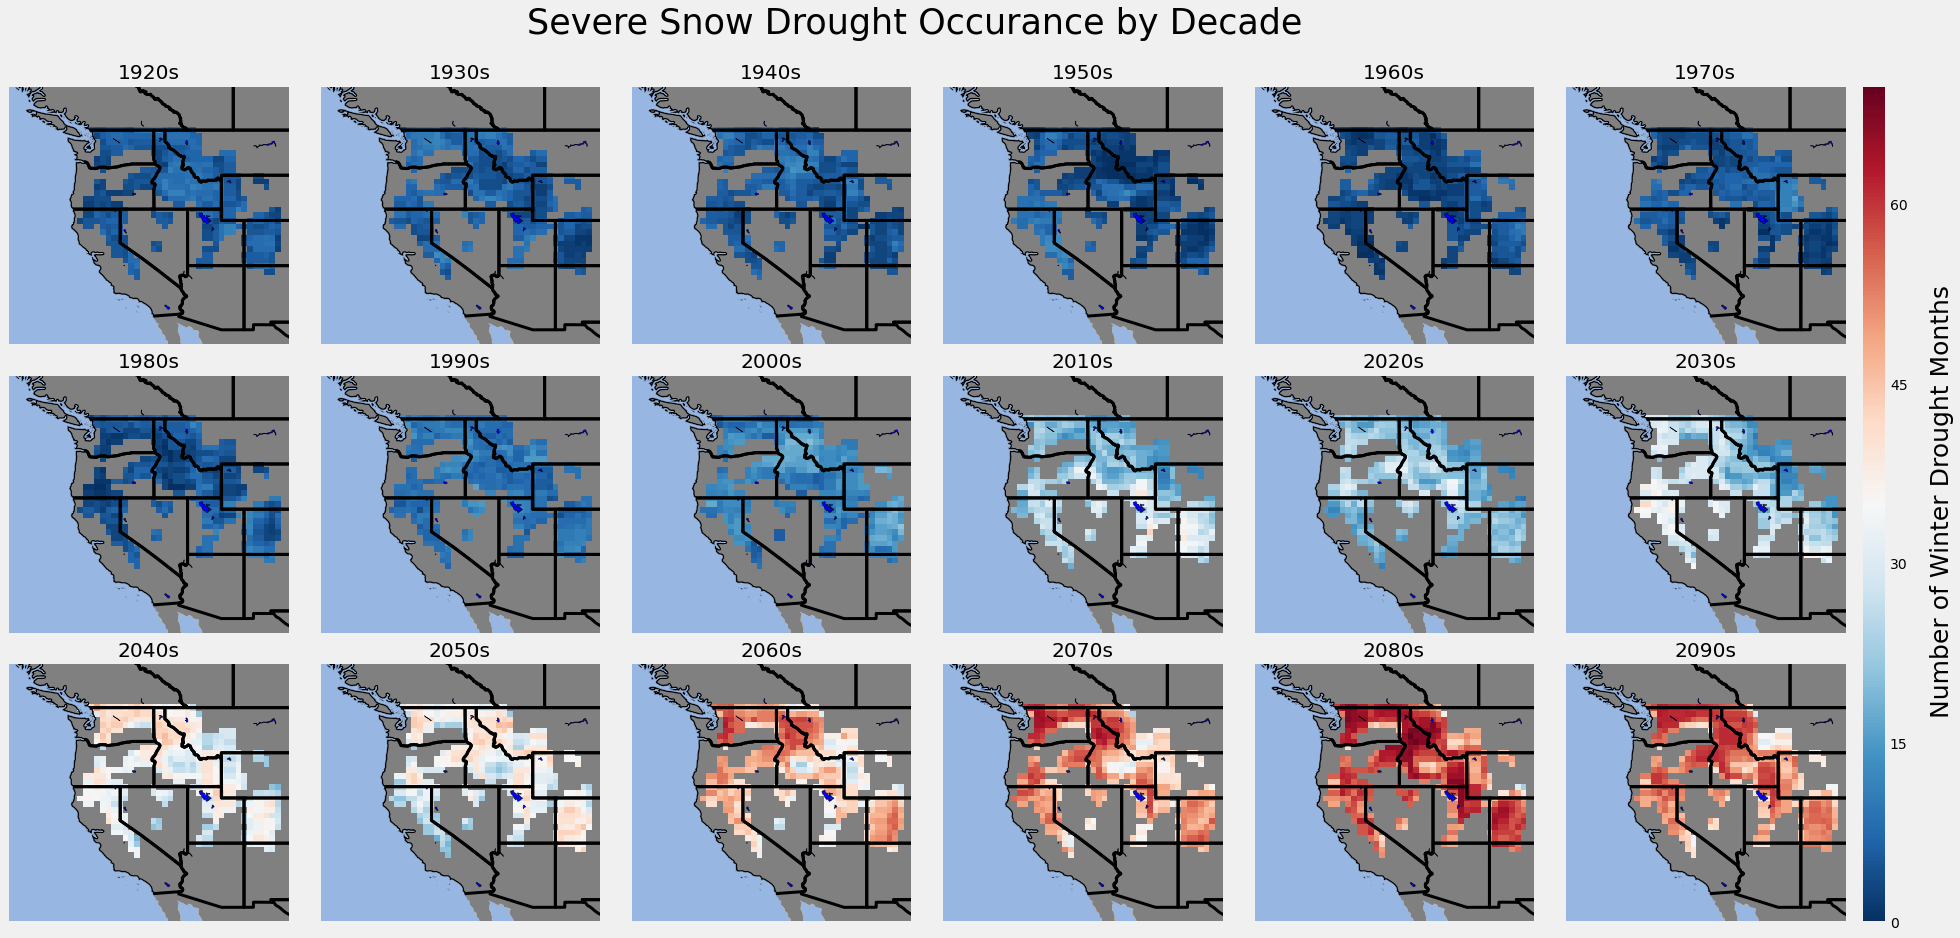

In [215]:
projection = ccrs.PlateCarree()
axes_class = (GeoAxes,
              dict(map_projection=projection))
cmap = matplotlib.cm.get_cmap("RdBu_r")
cmap.set_bad(color='gray')
vmin, vmax = 0, 70
fig = plt.figure(figsize=(30,20))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3, 6),
                axes_pad=0.4,
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='3%',
                label_mode='')  # note the empty label_mode

for j, ax in enumerate(axgr):
    i=j+1
    if i >18:
        break
    ax.add_feature(cfeature.LAND, edgecolor="orange", facecolor="grey", zorder=0)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor="blue")
    ax.add_feature(cfeature.OCEAN, zorder=2)
    ax.set_extent((-130, -105, 30, 53), crs=ccrs.PlateCarree())
    ax.add_feature(states, edgecolor='black', linewidth=3)
    data = decadal01.snow[i].where(mask_ds.snow >20).plot(ax=ax, transform = projection, add_colorbar=False,
             cmap=cmap, zorder=1, vmin=vmin, vmax=vmax)
#     masking = (mask_ds.snow <20).plot(ax=ax, transform = projection, add_colorbar=False, 
#                                      color="white", zorder =2)
    decade = decadal01.indexes['time'][i].year // 10 * 10 -10
    ax.set_title(f"{decade}s")
#     ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
#     ax.set_yticks(np.linspace(-90, 90, 5), crs=projection)
#     lon_formatter = LongitudeFormatter(zero_direction_label=True)
#     lat_formatter = LatitudeFormatter()
#     ax.xaxis.set_major_formatter(lon_formatter)
#     ax.yaxis.set_major_formatter(lat_formatter)

#     p = ax.contourf(lons, lats, data[i, ...],
#                     transform=projection,
#                     cmap='RdBu')

axgr.cbar_axes[0].colorbar(data)#, label="Number of Winter Drought Months")
#axgr.cbar_axes[0].label.set_text("Number")
#axgr.cbar_axes[0].set_title("Number of Winter Drought Months", rotation='vertical')
#axgr.sup_title("Severe Drought Occurance by Decade")
fig.suptitle("Severe Snow Drought Occurance by Decade", y=0.82, fontsize=35)
fig.text(0.97, 0.33, 'Number of Winter Drought Months', rotation=90, fontsize=25)

#plt.savefig("/home/Julian.Schmitt/plots/severe_SD_by_decade.png", dpi=350)